
# TP4: Encodeador de música



## Indice
1.
2.
3.
4.



## Importe de librerias e inicializacion

In [ ]:
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu


In [ ]:
%pip install pydub scikit-learn wandb torchview torchviz graphviz matplotlib tqdm

In [ ]:
%pip install wandb

In [ ]:
!pip install torchaudio
!pip install  pydub
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
import IPython
from tqdm import tqdm
import gc
from sklearn.metrics import accuracy_score, confusion_matrix


import wandb
wandb.login()
%matplotlib inline


wandb: Currently logged in as: osaintnom (chicas_superpoderosas). Use `wandb login --relogin` to force relogin


bfbad9b2649155692b5f97a49a43c0eeb66dff4a

In [ ]:
device = torch.device(
    'mps:0' if torch.backends.mps.is_available() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
    )

device

device(type='cuda', index=0)

## Importe de datos y visualizacion

In [ ]:
project_name='Music_genre_classification'

### Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [ ]:
import os
data_dir='/content/drive/MyDrive/genres_5sec/'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

['rock',
 'pop',
 'hiphop',
 'disco',
 'blues',
 'reggae',
 'country',
 'metal',
 'classical',
 'jazz']

In [ ]:
samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
            fname = self.files[i]

            #img = self.transform(open_image(fpath))
            genre = parse_genres(fname)
            fpath = os.path.join(self.root,genre, fname)
            genre_index = self.classes.index(genre)
            audio = torchaudio.load(fpath)[0]

            spectogram = tt.Spectrogram()(audio)

            return audio,spectogram, genre_index

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        # List classes
        fmt_str += '    Classes: {}\n'.format(self.classes)
        return fmt_str
dataset = MusicDataset(data_dir)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Separamos en train y val

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

(790, 100, 100)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualización de los archivos

In [ ]:

waveform,spectogram,label= dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))
# label = 9 es rock

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 8 


shape of spectogram torch.Size([1, 201, 552])


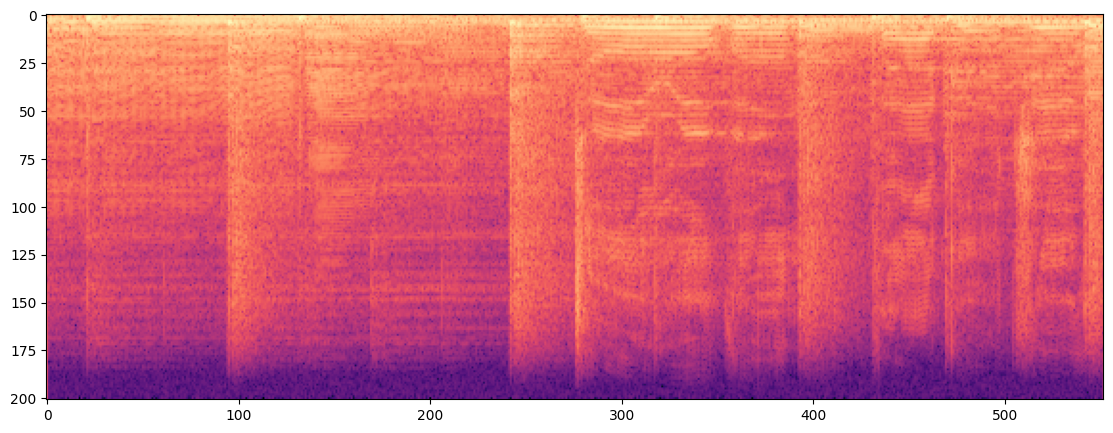

In [ ]:
print("shape of spectogram {}".format(spectogram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(spectogram.log2()[0,:,:].numpy(),cmap='magma')

Waveform: tensor([[0.1008, 0.1524, 0.1216,  ..., 0.2740, 0.2587, 0.2402]])



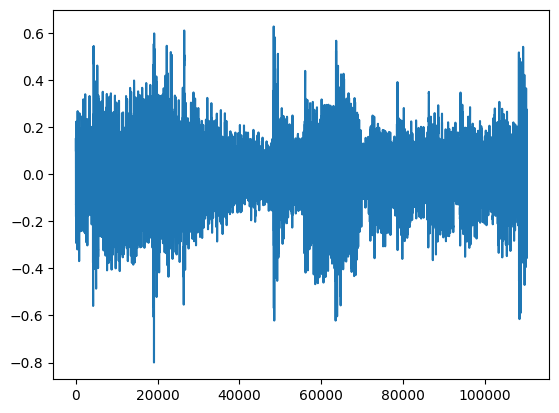

In [ ]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

Escuchamos el espectograma con la librería de audio

In [ ]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

In [ ]:
spectogram.size()

torch.Size([1, 201, 552])

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

(790, 100, 100)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

## Ejercicio 1

### Arquitectura: Autoencoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_input, c_1, c_2, c_3, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv1d(n_input, c_1, kernel_size=k_1, padding=p_1, stride=s_1)
        self.conv2 = nn.Conv1d(c_1, c_2, kernel_size=k_2, padding=p_2, stride=s_2)
        self.conv3 = nn.Conv1d(c_2, c_3, kernel_size=k_3, padding=p_3, stride=s_3)
        # self.conv4 = nn.Conv1d(ec_3, ec_4, kernel_size=ek_4, padding=ep_4, stride=es_4)

    def forward(self, x):
        # print("Encoder input shape:", x.shape)

        x = F.leaky_relu(self.conv1(x))
        # print("Encoder Conv1 shape:", x.shape)

        x = F.leaky_relu(self.conv2(x))
        # print("Encoder Conv2 shape:", x.shape)

        x = F.leaky_relu(self.conv3(x))
        # print("Encoder Conv3 shape:", x.shape)

        # x = F.softsign(self.conv4(x))
        # print("Bottle_neck shape:", x.shape)
        return x

class Decoder(nn.Module):
    def __init__(self, n_input, c_1, c_2, c_3, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4):
        super(Decoder, self).__init__()

        # self.deconv4 = nn.ConvTranspose1d(dc_4, dc_3, kernel_size=dk_4, stride=ds_4, padding=dp_4)
        self.deconv3 = nn.ConvTranspose1d(c_3, c_2, kernel_size=k_3, stride=s_3, padding=p_3)
        self.deconv2 = nn.ConvTranspose1d(c_2, c_1, kernel_size=k_2, stride=s_2, padding=p_2)
        self.deconv1 = nn.ConvTranspose1d(c_1, n_input, kernel_size=k_1, stride=s_1, padding=p_1)

    def forward(self, x):
        # x = F.softsign(self.deconv4(x))
        # print("Decoder Conv4 shape:", x.shape)

        x = F.leaky_relu(self.deconv3(x))
        # print("Decoder Conv3 shape:", x.shape)

        x = F.leaky_relu(self.deconv2(x))
        # print("Decoder Conv2 shape:", x.shape)

        x = self.deconv1(x)
        # print("Decoder Conv1 shape:", x.shape)
        return x

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.bottle_neck = None

    def forward(self, x):
        x = self.encoder(x)
        self.bottle_neck = x.shape
        x = self.decoder(x)
        return x

n_input = 1
# Channels
c_1 = 64
c_2 = 32
c_3 = 16
c_4 = 4

# Kernel size
k_1 = 8
k_2 = 6
k_3 = 5
k_4 = 2

# Stride
s_1 = 6
s_2 = 3
s_3 = 2
s_4 = 3

# Padding
p_1 = 4
p_2 = 4
p_3 = 4
p_4 = 4

audio_size = (batch_size, 1, 110250)  # Ejemplo de forma
encoder = Encoder(n_input, c_1, c_2, c_3, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4)
decoder = Decoder(n_input, c_1, c_2, c_3, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4)
model = Autoencoder(encoder, decoder).to(device)

dummy_input = torch.rand(audio_size).to(device)
output = model(dummy_input)
print('Bottle Neck:', model.bottle_neck, (model.bottle_neck[1]*model.bottle_neck[2]))
print("Output shape:", output.size())
print(model)

# output comun = (input_size + 2p - kernel)/stride + 1.
# output traspuesta = (input_size - 1) * stride - 2Padding + kernel.


Encoder input shape: torch.Size([20, 1, 110250])
Bottle Neck: torch.Size([20, 4, 3066]) 12264
Output shape: torch.Size([20, 1, 110250])
Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(6,), padding=(4,))
    (conv2): Conv1d(64, 32, kernel_size=(6,), stride=(3,), padding=(4,))
    (conv3): Conv1d(32, 4, kernel_size=(5,), stride=(2,), padding=(4,))
  )
  (decoder): Decoder(
    (deconv3): ConvTranspose1d(4, 32, kernel_size=(5,), stride=(2,), padding=(4,))
    (deconv2): ConvTranspose1d(32, 64, kernel_size=(6,), stride=(3,), padding=(4,))
    (deconv1): ConvTranspose1d(64, 1, kernel_size=(8,), stride=(6,), padding=(4,))
  )
)


### Entrenamos autoencoder

In [ ]:
# train
import gc


lr=0.001
num_epochs = 25
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
torch.cuda.empty_cache()
gc.collect()
valid_losses = []

log = True
if log:
    Bott_neck = model.bottle_neck[1:]
    Bott_neck = str(model.bottle_neck[1:][0])+','+ str(model.bottle_neck[1:][1])
    wandb.finish()
    wandb.init(
        project=project_name,
        name=f"{model.__class__.__name__}_EL:[{Bott_neck}]",
      # trackeamos los hiperparámetros y las métricas
      config={
          "learning_rate": lr,
          "batch_size": batch_size,
          "epochs": num_epochs,
          "c_1" : c_1,
          "c_2" : c_2,
          "c_3" : c_3,
          "c_4" : c_4,
          "k_1" : k_1,
          "k_2" : k_2,
          "k_3" : k_3,
          "k_4" : k_4,
          "s_1" : s_1,
          "s_2" : s_2,
          "s_3" : s_3,
          "s_4" : s_4,
          "p_1" : p_1,
          "p_2" : p_2,
          "p_3" : p_3,
          "p_4" : p_4
          },
    )

for epoch in range(num_epochs):
     train_loss = []
     val_loss = []

     # TRAIN
     model.train()
     for wav,spectogram, genre_index in train_dl:
        optimizer.zero_grad()
        wav=wav.to(device)

        # Forward
        out = model(wav)
        #print("Output shape:", out.shape)
        #print("Target shape:", wav.shape)
        loss = loss_function(out, wav)

        # Backward
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        # Liberamos memoria ram
        del spectogram
        del wav
        del loss
        del out
        torch.cuda.empty_cache()
        gc.collect()

    # VALIDATION
     model.eval()
     with torch.no_grad():
        for wav,spectogram, genre_index in valid_dl:
            wav = wav.to(device)

            out = model(wav)
            loss = loss_function(out, wav)
            val_loss.append(loss.item())

            # Liberamos memoria ram
            del spectogram
            del wav
            del genre_index
            del loss
            del out
            torch.cuda.empty_cache()
            gc.collect()

     valid_loss = np.mean(val_loss)
     if log:
        wandb.log({
          "train_loss": np.mean(train_loss),
          "val_loss":  valid_loss})
     print('Epoch: [%d/%d], Train loss: %.4f, Valid loss: %.4f' % (epoch+1, num_epochs,np.mean(train_loss),  valid_loss))

    # Save model
     valid_losses.append(valid_loss.item())
     if np.argmin(valid_losses) == epoch:
         print('Saving the best model at %d epochs!' % epoch)
         torch.save(model.state_dict(), 'best_model.ckpt')

if log:
  wandb.finish()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape: torch.Size([20, 1, 110250])
Encoder input shape:

train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.0038
val_loss,0.00341


In [ ]:
# Load the best model
S = torch.load('best_model.ckpt')
model.load_state_dict(S)
print('loaded!')

# Run evaluation
model.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for audio,spectogram, genre_index in test_dl:
        audio = audio.to(device)
        genre_index = genre_index.to(device)

        out = model(audio)

        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

accuracy =correct/ len(test_dl.dataset)
print('Epoch: [%d/%d], Valid loss: %.4f' % (epoch+1, num_epochs, valid_loss))


loaded!
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size([1, 1, 110250])
Encoder input shape: torch.Size(

### Display

In [ ]:
original = test_dl.dataset[18]
print(original)
audio = original[0]
idnex = original[2]
print("shape of waveform {}, sample rate with {}, label is {} ".format(audio.size(),samplerate,idnex))

(tensor([[-0.0610, -0.0823, -0.0913,  ...,  0.0116, -0.0370, -0.0383]]), tensor([[[9.1148e-02, 6.9819e-01, 8.2049e-02,  ..., 1.9524e-01,
          3.4501e-01, 1.1315e-01],
         [3.7214e-01, 1.0255e-01, 6.5085e+00,  ..., 7.1069e-02,
          1.3006e-02, 9.0316e-01],
         [3.1336e+01, 1.8434e+01, 1.1791e+00,  ..., 7.2356e-01,
          8.4003e-02, 9.6355e-01],
         ...,
         [1.5004e-03, 4.8157e-09, 8.5789e-10,  ..., 8.3519e-09,
          1.2942e-09, 9.7523e-05],
         [1.5024e-03, 2.9348e-09, 4.3332e-09,  ..., 1.2914e-08,
          2.4949e-08, 9.7601e-05],
         [1.5033e-03, 1.6792e-09, 7.8213e-09,  ..., 3.1974e-08,
          7.3760e-08, 1.0024e-04]]]), 8)
shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 8 


<built-in method size of Tensor object at 0x7f41d80fdad0>
Encoder input shape: torch.Size([1, 1, 110250])
spectogram shape:  torch.Size([1, 1, 201, 552])
reconstructed spectogram shape:  torch.Size([1, 201, 552])

waveform shape:  torch.Size([1, 1, 110250])
waveform new shape:  torch.Size([1, 110250])
Audio Original


Audio Reconstruido


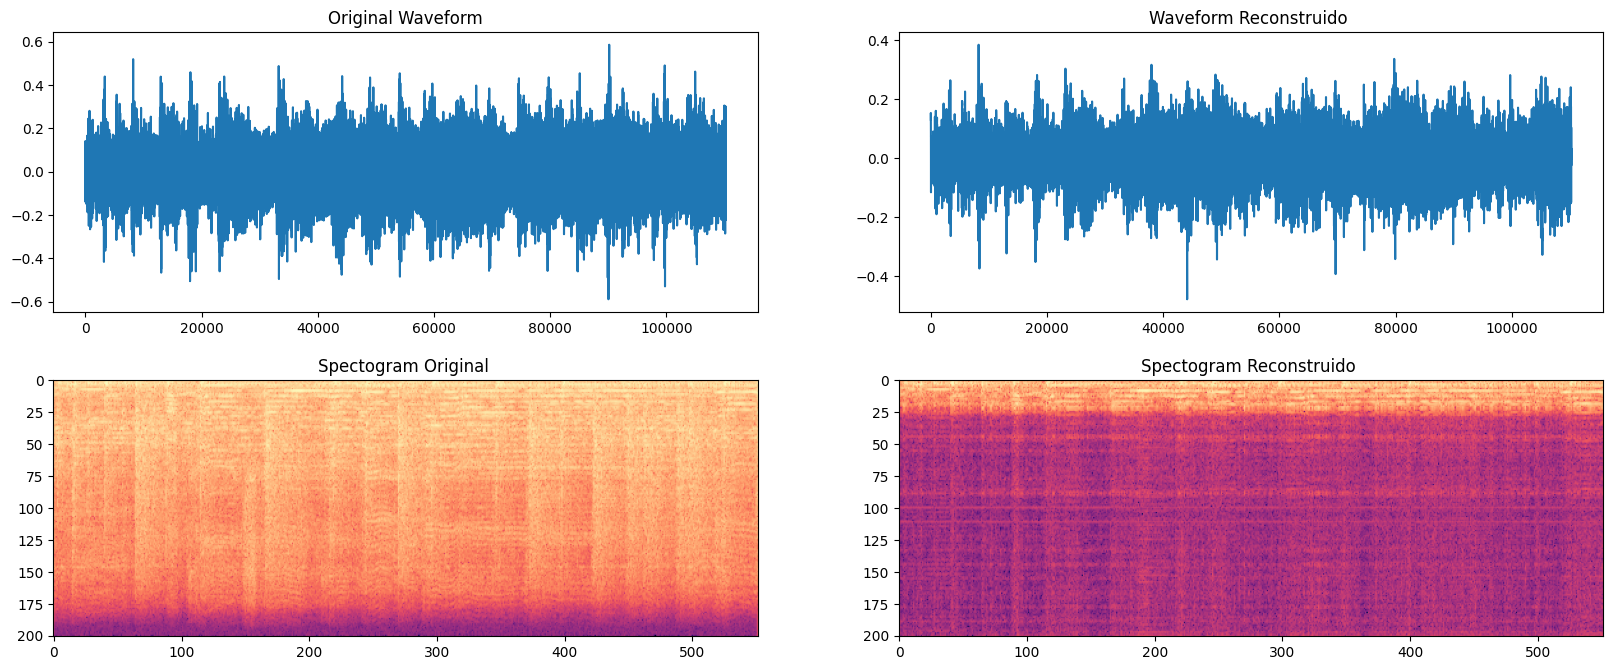

In [ ]:
model.eval()
#original
waveform, spectogram, label = test_dl.dataset[18]
print(waveform.size)
audio = waveform.to(device)
spec = spectogram.to(device)
#reconstruccion
rec_audio = model(audio).to('cpu').squeeze(0).detach()
rec_spec = tt.Spectrogram()(rec_audio)

print("spectogram shape: ", spectogram.shape)
print("reconstructed spectogram shape: ", rec_spec.shape)
print()
print("waveform shape: ", waveform.shape)
print("waveform new shape: ", rec_audio.shape)


fig, axs = plt.subplots(2, 2, figsize=(20, 8))

axs[0, 0].plot(audio.squeeze().detach().cpu().numpy())
axs[0, 0].set_title("Original Waveform")

axs[0, 1].plot(rec_audio.t().numpy())
axs[0, 1].set_title("Waveform Reconstruido ")

axs[1, 0].imshow(spec.log2().squeeze().detach().cpu().numpy(), cmap='magma')
axs[1, 0].set_title("Spectogram Original ")

axs[1, 1].imshow(rec_spec.log2().squeeze().detach().cpu().numpy(), cmap='magma')
axs[1, 1].set_title("Spectogram Reconstruido ")

print("Audio Original")
display(IPython.display.Audio(waveform.squeeze(), rate=samplerate))
print("Audio Reconstruido")
display(IPython.display.Audio(rec_audio, rate=samplerate))

## Ejerecio 2

Importo los 3 modelos distinos:
* Chico  (X1/2)
* Normal (X1)
* Grande (X2)
(tengo que giardarme el label por cada vector latente que tengo)



Guardo los vectoreslatentes en 3 matrices dsitintas

hago clastering y me fijo si segmenta bien las clases para cada uno de lo modelos

PCA?

Analizis a mano de graficos?

## Ejerecio 3

corregir el sample rate

Reduccion de canales

importe de cancion y reproduccion

In [ ]:
import os
data_dir='/content/drive/MyDrive/musica_nueva_5sec/'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

In [ ]:
nuevo_dataset = MusicDataset(data_dir)

In [ ]:
audio, spectogram, class_idx = nuevo_dataset[2]
print("shape of waveform {}, sample rate with {}, label is {} ".format(audio.size(),samplerate,class_idx))

In [ ]:
S = torch.load('buenisimo.ckpt')
model.load_state_dict(S)
print('loaded!')
waveform = waveform.to(device)  # Move the input data to the same device as the model
model = model.to(device)  # Make sure the model is on the correct device

model.eval()

new_wav = model(waveform)

In [ ]:
waveform, spectogram, label = nuevo_dataset[2]
print(waveform.size)
audio = waveform.to(device)
spec = spectogram.to(device)
#reconstruccion
rec_audio = model(audio).to('cpu').squeeze(0).detach()
rec_spec = tt.Spectrogram()(rec_audio)

fig, axs = plt.subplots(2, 2, figsize=(20, 8))

axs[0, 0].plot(audio.squeeze().detach().cpu().numpy())
axs[0, 0].set_title("Original Waveform")

axs[0, 1].plot(rec_audio.t().numpy())
axs[0, 1].set_title("Waveform Reconstruido ")

axs[1, 0].imshow(spec.log2().squeeze().detach().cpu().numpy(), cmap='magma')
axs[1, 0].set_title("Spectogram Original ")

axs[1, 1].imshow(rec_spec.log2().squeeze().detach().cpu().numpy(), cmap='magma')
axs[1, 1].set_title("Spectogram Reconstruido ")

print("Audio Original")
display(IPython.display.Audio(waveform.squeeze(), rate=samplerate))
print("Audio Reconstruido")
display(IPython.display.Audio(rec_audio, rate=samplerate))

## Ejerecio 4